In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sentence_transformers import SentenceTransformer

# from sklearn.metrics import zero_one_loss, accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

import scipy

import sklearn.tree as tree
import math

from pathlib import Path

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)


DATA_PATH = Path('data/original-dataset')
VOCAB_PATH = DATA_PATH.joinpath('imdb.vocab')
TRAIN_BOW_PATH = DATA_PATH.joinpath('train/labeledBow.feat')
TEST_BOW_PATH = DATA_PATH.joinpath('test/labeledBow.feat')
TRAIN_FILES = DATA_PATH.glob('train/[pn][oe][sg]/*.txt')
TEST_FILES = DATA_PATH.glob('test/[pn][oe][sg]/*.txt')
COLORMAP = 'seismic'

# data processing constants
MAX_DF = 0.5
MIN_DF = 2
PCA_COMPONENTS = 100


# just tf-idf score (row normalized)
# just tf-idf score without stop words
# tf-idf score with PCA
# tf-idf score with PCA without stop words

C:\Users\User\miniconda3\envs\cs178\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_FILES = list(TRAIN_FILES)
TEST_FILES = list(TEST_FILES)

print(len(TRAIN_FILES))
print(len(TEST_FILES))

def y_label(review_path):
    rating = int(review_path.stem.split('_')[1])
    return 1 if rating > 5 else -1

ytr = np.array([ y_label(path) for path in TRAIN_FILES])
yte = np.array([ y_label(path) for path in TEST_FILES])

25000
25000


In [3]:
feature_models = {
    'tfidf': {'Xtr': None, 'Xte': None},
    'tfidf stop': {'Xtr': None, 'Xte': None},
    'tfidf PCA (100)': {'Xtr': None, 'Xte': None},
    'tfidf stop PCA (100)': {'Xtr': None, 'Xte': None},
    'sBERT Embedding (100)': {'Xtr': None, 'Xte': None}
}

In [4]:
# Transforms review text into a vector of normalized tf-idf scores where each column corresponds to a term

print('starting')
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', norm='l2'))
]).fit(TRAIN_FILES)

sorted_terms = sorted((tfidf_pipe['tfidf'].idf_[index], term) for term, index in tfidf_pipe['tfidf'].vocabulary_.items())
print(f"Number of terms: {len(tfidf_pipe['tfidf'].vocabulary_)}")
print(f"Top appearing words:\n{sorted_terms[:10]}")

transforms = feature_models['tfidf']
transforms['Xtr'] = tfidf_pipe.transform(TRAIN_FILES)
transforms['Xte'] = tfidf_pipe.transform(TEST_FILES)

starting
Number of terms: 74849
Top appearing words:
[(1.008314135652267, 'the'), (1.0340105187711748, 'and'), (1.0522600386726457, 'of'), (1.0629372013721339, 'to'), (1.09919757073324, 'this'), (1.10865023392407, 'is'), (1.115002017669703, 'it'), (1.1260568397835082, 'in'), (1.2070149693526475, 'that'), (1.329544566505641, 'but')]


In [30]:
# Transforms review text into a vector of normalized tf-idf scores where each column corresponds to a term
# This vectorization does not include terms in > 50% of the documents or terms in only one document
print(len(list(TRAIN_FILES)))
print('starting')
tfidf_stop_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', norm='l2', max_df=MAX_DF))
]).fit(TRAIN_FILES)

sorted_terms = sorted((tfidf_stop_pipe['tfidf'].idf_[index], term) for term, index in tfidf_stop_pipe['tfidf'].vocabulary_.items())
print(f"Number of terms: {len(tfidf_stop_pipe['tfidf'].vocabulary_)}")
print(f"Top appearing words:\n{sorted_terms[:10]}")

transforms = feature_models['tfidf stop']
transforms['Xtr'] = tfidf_stop_pipe.transform(TRAIN_FILES)
transforms['Xte'] = tfidf_stop_pipe.transform(TEST_FILES)

25000
starting
Number of terms: 74807
Top appearing words:
[(1.9223488033997396, 'what'), (1.9522688378798054, 'some'), (1.9527872680847915, 'good'), (1.9547597576939584, 'can'), (2.0142743754043027, 'more'), (2.0179205868358094, 'when'), (2.051577880482202, 'time'), (2.0587010723659036, 'up'), (2.0588163793709313, 'very'), (2.088305995813987, 'even')]


In [6]:
# Transforms review text into a vector of the 100 largest principal components of the tf-idf vector

print('starting')
tfidf_pca_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', norm='l2')),
    ('svd', TruncatedSVD(n_components=PCA_COMPONENTS, algorithm='arpack')),
    ('norm', Normalizer(norm='l2'))
]).fit(TRAIN_FILES)

print(tfidf_pca_pipe['svd'].singular_values_)
print(tfidf_pca_pipe['svd'].explained_variance_ratio_)

transforms = feature_models['tfidf PCA (100)']
transforms['Xtr'] = tfidf_pca_pipe.transform(TRAIN_FILES)
transforms['Xte'] = tfidf_pca_pipe.transform(TEST_FILES)

starting
[54.65891888 13.5102238  12.79904101  9.8554702   9.10612403  8.39122164
  8.1808897   7.93647635  7.58407459  7.06695881  6.96318136  6.66223256
  6.50845629  6.35585221  6.18841767  6.06035663  5.69538676  5.6170094
  5.46927002  5.39525987  5.28998828  5.27702923  5.24512621  5.18554463
  5.15021639  5.04610149  4.99621167  4.96877061  4.94125512  4.81736395
  4.77980955  4.75037253  4.71513501  4.69388025  4.65940478  4.64448641
  4.62677912  4.57991376  4.56781248  4.56191947  4.51491515  4.47765129
  4.46981404  4.45275512  4.43885221  4.42746863  4.42213615  4.38177575
  4.36924251  4.35579305  4.32072653  4.31720049  4.29497183  4.28964809
  4.26886973  4.25987924  4.24263091  4.23401665  4.21492532  4.19712404
  4.18197244  4.17705185  4.16299535  4.15088578  4.14209026  4.12840679
  4.11422708  4.07980799  4.07349028  4.06864937  4.05402221  4.0379094
  4.03302017  4.01043881  3.99915594  3.99017694  3.978159    3.96857289
  3.96398616  3.95332369  3.94731316  3.9311

In [7]:
# Transforms review text into a vector of the 100 largest principal components of the tf-idf vector
# This vectorization does not include terms in > 50% of the documents or terms in only one document

print('starting')
tfidf_pca_stop_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(input='filename', norm='l2', max_df=MAX_DF, min_df=MIN_DF)),
    ('svd', TruncatedSVD(n_components=PCA_COMPONENTS, algorithm='arpack')),
    ('norm', Normalizer(norm='l2'))
]).fit(TRAIN_FILES)


print(tfidf_pca_stop_pipe['svd'].singular_values_)
print(tfidf_pca_stop_pipe['svd'].explained_variance_ratio_)

transforms = feature_models['tfidf stop PCA (100)']
transforms['Xtr'] = tfidf_pca_stop_pipe.transform(TRAIN_FILES)
transforms['Xte'] = tfidf_pca_stop_pipe.transform(TEST_FILES)

starting
[28.08140773 10.06980569  8.10585976  7.52292096  7.07218213  6.79512768
  6.28819711  6.26508273  6.04715284  5.81593504  5.71226509  5.60233955
  5.50898792  5.44313683  5.34742121  5.32644107  5.26528791  5.24908213
  5.20689789  5.15210224  5.07774344  5.03429671  4.97792161  4.92292713
  4.9051308   4.86079953  4.8371571   4.7972661   4.77866402  4.74200835
  4.73912072  4.7202972   4.70475769  4.69095278  4.65631607  4.64423152
  4.61701328  4.60986515  4.57378701  4.55368827  4.54016578  4.51863127
  4.50871852  4.48257625  4.47255448  4.45271639  4.44050295  4.41090566
  4.40860529  4.39856359  4.38209627  4.37323762  4.35652325  4.34224017
  4.31376637  4.29130353  4.28567114  4.27521185  4.26966697  4.25191315
  4.23056591  4.22973425  4.22013324  4.20600713  4.20106264  4.18666918
  4.17999375  4.17748505  4.15663992  4.14248832  4.12851382  4.12257462
  4.10434417  4.09856888  4.09463173  4.08851844  4.07587692  4.05788589
  4.05141607  4.04356284  4.03309064  4.02

In [22]:
embedding_model = SentenceTransformer('sBERT_IMBD_Embedding_Model')

tr_contents = []
for path in TRAIN_FILES:
    with open(path, 'r', encoding='utf8') as file:
        tr_contents.append(file.read().strip())

te_contents = []
for path in TEST_FILES:
    with open(path, 'r', encoding='utf8') as file:
        te_contents.append(file.read().strip())

print(len(tr_contents))
print(len(te_contents))
print('here')
print(embedding_model)
transforms = feature_models['sBERT Embedding (100)']
transforms['Xtr'] = embedding_model.encode(tr_contents, show_progress_bar=True) #normalize_embeddings=True)
transforms['Xte'] = embedding_model.encode(te_contents, show_progress_bar=True) #normalize_embeddings=True)

print(transforms['Xtr'].shape)
print(transforms['Xtr'][0])
print(transforms['Xte'][0])

25000
25000
here
SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
  (dense): Dense({'in_features': 384, 'out_features': 100, 'bias': True, 'activation_function': 'torch.nn.modules.activation.ReLU'})
)


Batches: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [03:41<00:00,  3.53it/s]


(25000, 100)
[0.         0.         0.07421463 0.03770085 0.00036846 0.05933767
 0.02271885 0.05166288 0.08300117 0.         0.10310113 0.
 0.         0.00262931 0.         0.07426202 0.         0.
 0.05672095 0.12668926 0.02614808 0.02679442 0.         0.02175005
 0.         0.         0.1385632  0.         0.         0.00109423
 0.         0.         0.02387523 0.         0.14528972 0.
 0.0196334  0.         0.         0.         0.         0.00532224
 0.01723314 0.         0.         0.         0.         0.
 0.00331354 0.04119869 0.         0.00933843 0.         0.03053601
 0.         0.10197641 0.05452932 0.03968683 0.         0.09700622
 0.         0.         0.         0.20986614 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01521233 0.         0.         0.19989647
 0.         0.01210853 0.         0.         0.00040399 0.
 0.         0.         0.00528132 0.03936435 0.         0.
 0.         0.0013384  0.04257473 0.         0

Training Learner on tfidf features
finished transform
finished fitting in 33.12 seconds
train acc: 0.99992
test acc : 0.85344
finished fitting in 70.14 seconds
train acc: 0.99676
test acc : 0.84308
finished fitting in 125.43 seconds
train acc: 0.99932
test acc : 0.85764
finished fitting in 123.99 seconds
train acc: 0.99916
test acc : 0.84864
finished fitting in 1254.19 seconds
train acc: 0.99996
test acc : 0.86168
Training Learner on tfidf stop features
finished transform
finished fitting in 7.20 seconds
train acc: 0.99952
test acc : 0.84128
finished fitting in 47.74 seconds
train acc: 0.99996
test acc : 0.83372
finished fitting in 72.80 seconds
train acc: 0.9996
test acc : 0.84436
finished fitting in 59.53 seconds
train acc: 0.99992
test acc : 0.83208
finished fitting in 250.11 seconds
train acc: 0.99844
test acc : 0.8342
Training Learner on tfidf PCA (100) features
finished transform
finished fitting in 1.40 seconds
train acc: 0.85484
test acc : 0.851
finished fitting in 1.69 seconds

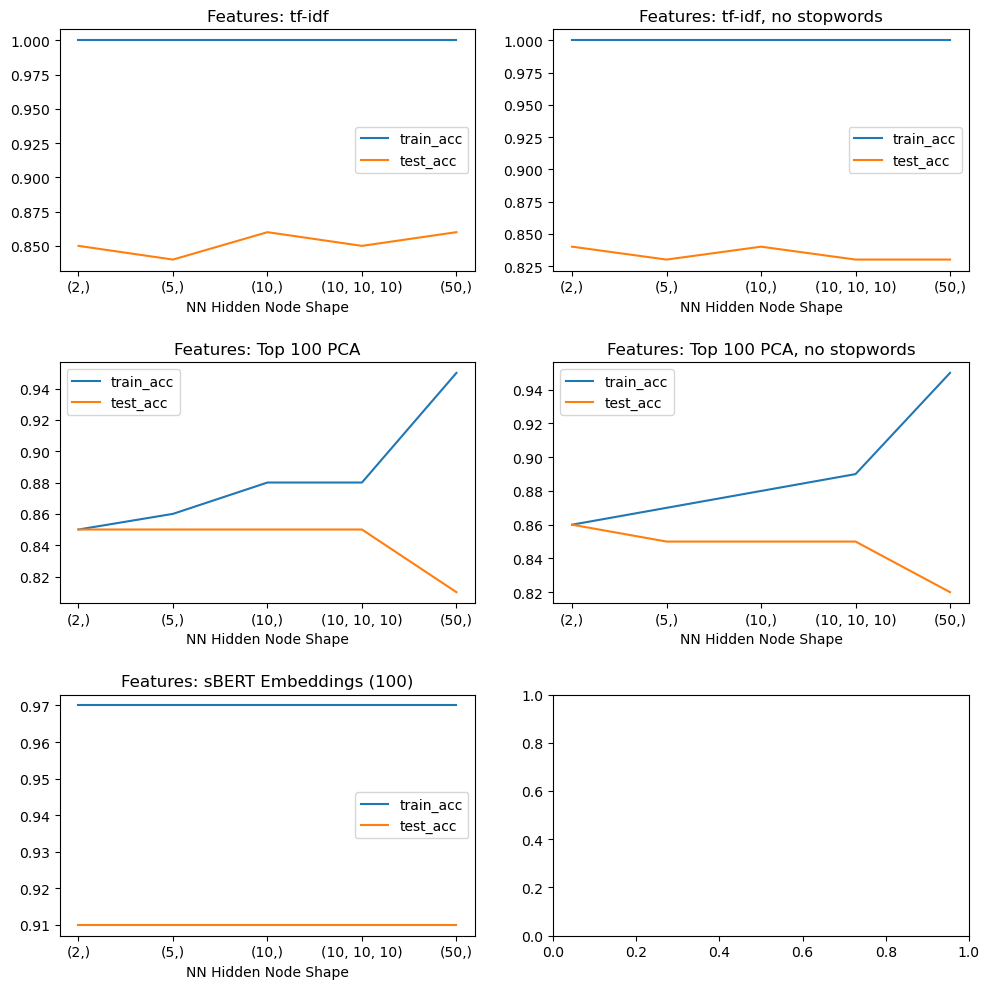

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

coords = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0)]
titles = ['Features: tf-idf', 'Features: tf-idf, no stopwords', 'Features: Top 100 PCA', 'Features: Top 100 PCA, no stopwords', 'Features: sBERT Embeddings (100)']
for i, (fm_name, transforms) in enumerate(feature_models.items()):
    print(f'Training Learner on {fm_name} features')
    print('finished transform')
    
    layer_sizes = [(2,), (5,), (10,), (10, 10, 10), (50,)]
    tr_acc = []
    te_acc = []
    
    for layer_size in layer_sizes:
        learner = MLPClassifier(
            solver='adam', 
            hidden_layer_sizes=layer_size,
            alpha=0.001,
            learning_rate_init=0.01,
            tol=0.001,
        )

#         learner = KNeighborsClassifier(n_neighbors=k)
        
        start = time.time()
        learner.fit(transforms['Xtr'], ytr)
        end = time.time()
        print(f'finished fitting in {(end-start):.2f} seconds')

        tr_score = learner.score(transforms['Xtr'], ytr)
        te_score = learner.score(transforms['Xte'], yte)
        tr_acc.append(np.round(tr_score, 2))
        te_acc.append(np.round(te_score, 2))
        print(f"train acc: {tr_score}")
        print(f"test acc : {te_score}")
    
    ax = axs[coords[i]]
    ax.plot(tr_acc, label='train_acc')
    ax.plot(te_acc, label='test_acc')
    ax.set_title(titles[i])
    ax.set_xlabel('NN Hidden Node Shape')
    ax.set_xticks(list(range(len(layer_sizes))))
    ax.set_xticklabels(map(lambda s: str(s), layer_sizes), rotation=0)
    ax.legend()

    
fig.tight_layout(h_pad=2, w_pad=2)        
        
